# Beaderstadt Final: Regression Analysis<br>
**Author:** Alissa Beaderstadt<br>
**Date:** November 18, 2025<br>

## Introduction
Medical costs can vary widely depending on factors like age, lifestyle, and region. In this project, I use the Kaggle Medical Costs Dataset to explore these relationships and see which features have the biggest impact on charges. I’ll walk through data exploration, feature engineering, and modeling with both linear and polynomial regression. Finally, I’ll compare model performance and visualize predictions in actual dollar amounts to connect the results to real world impact.

## Imports
Import the necessary Python libraries for this notebook.

In [10]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer  # keep only if actually used

# Evaluation metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


## Section 1. Import and Inspect the Data
### 1.1 Load the Medical Costs Dataset
For this project, I pulled the Medical Cost Personal dataset from the link below:<br>
https://www.kaggle.com/datasets/mirichoi0218/insurance

In [11]:
# Load Medical Cost dataset
df = pd.read_csv("data/insurance.csv")

# Display structure and first 10 rows
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


`Note:`<br>
- The dataset includes 6 features
- The target variable is: `charges`
- The dataset contains 1338 samples and 7 columns (6 features + target).

### 1.2 Check for Missing Values and Display Summary Statistics

In [12]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Summary statistics for categorical features
summary_counts = df.describe(include='all')
summary_counts

Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


**Reflection 1:**
- What do you notice about the dataset?
  - The dataset is fairly small, with 1,338 records and 7 features related to medical insurance costs.
  - It includes a few categorical variables (sex, smoker, region) that will need to be encoded before modeling.
  
-  Are there any data issues?
   -  The dataset is pretty clean and has no missing values. The only issue is that the categorical variables need to be converted into numerical form for regression.


## Section 2. Data Exploration and Preparation
### 2.1 Explore data patterns and distributions
- Since features in this dataset are a mix of categorical and numeric, I’ll use histograms for the numberic, boxplots to check for outliers, and countplots to explore feature distributions.

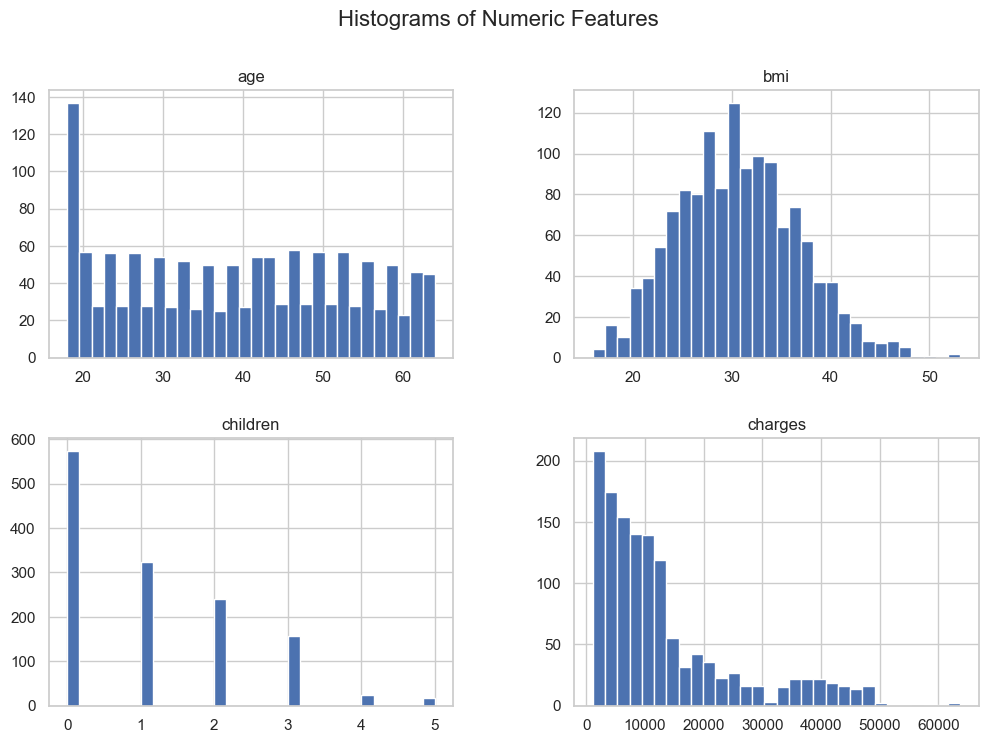

In [13]:
# Set a clean style
sns.set(style="whitegrid")

# ------------------------------
# Histograms for numeric features
# ------------------------------

numeric_cols = ["age", "bmi", "children", "charges"]

df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.show()

`Note:`<br>
- BMI looks roughly normally distributed, with a bit of right skew.
- Age appears fairly uniform in the histogram, with bars going up and down across the range. This may be due to the data being integers and the binning method, but overall there’s no skew.
- The number of children is heavily skewed toward 0-2, with very few larger families.
- Charges (the target) is strongly right-skewed, suggesting some extremely high-cost cases.

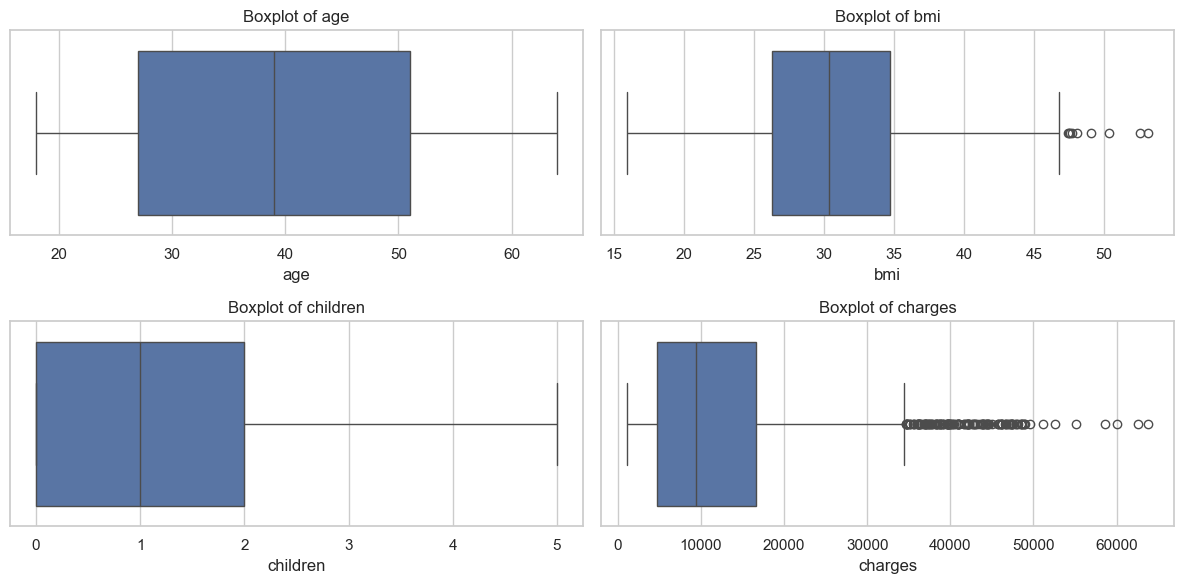

In [14]:
# ------------------------------
# Boxplots for numeric features (check for outliers)
# ------------------------------

plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

`Note:`<br>
- BMI and charges both show outliers, which makes sense since extreme high costs and high BMI values are expected in this type of data.
- Age and children show no outliers.
- Outliers in charges could impact the regression model, so it's something to keep in mind.

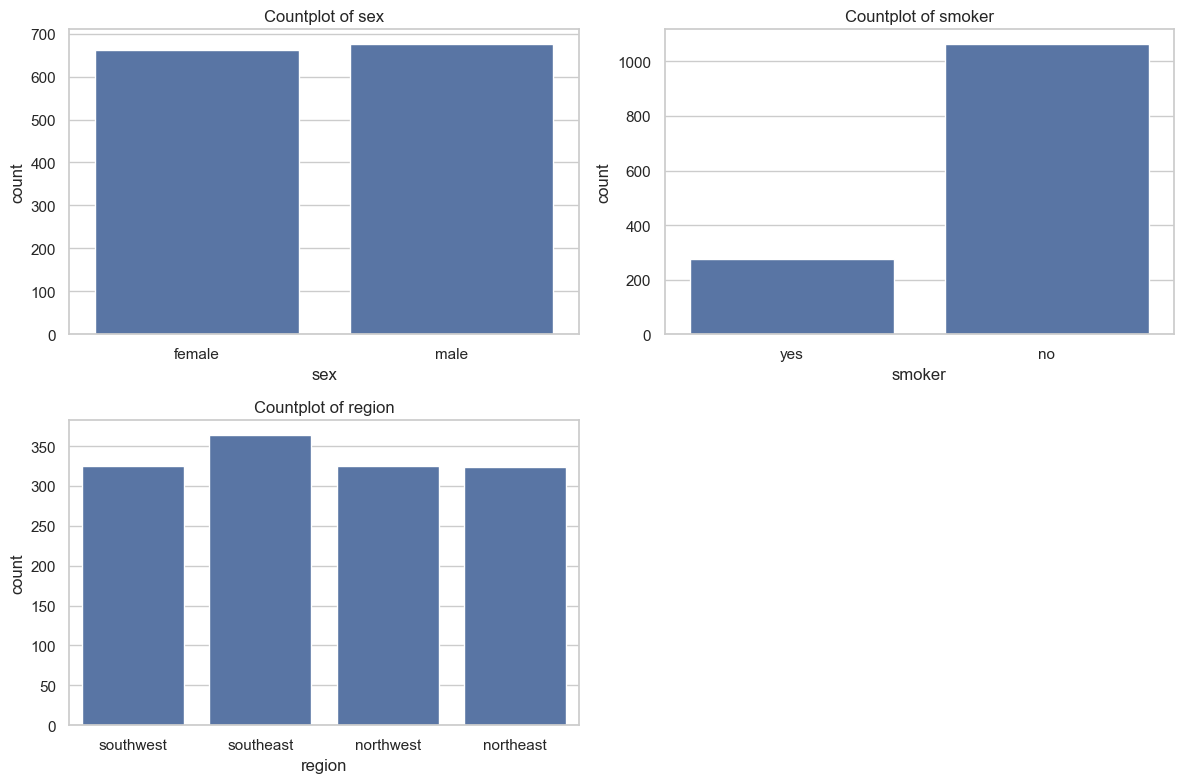

In [15]:
# ------------------------------
# Countplots for categorical features
# ------------------------------

categorical_cols = ["sex", "smoker", "region"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=df[col])
    plt.title(f"Countplot of {col}")
plt.tight_layout()
plt.show()

`Note:`<br>
- Sex is almost perfectly balanced between male and female.
- Most people in the dataset are non-smokers.
- The region variable is fairly evenly distributed across the four areas.

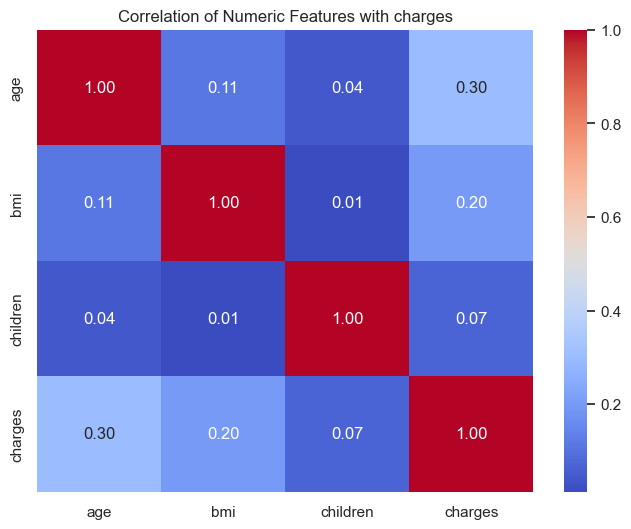

In [16]:
# ------------------------------
# Correlation heatmap for numeric features
# ------------------------------
plt.figure(figsize=(8,6))
sns.heatmap(df[['age', 'bmi', 'children', 'charges']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Numeric Features with charges")
plt.show()

`Note:`<br>
- Age and BMI show fairly strong positive correlations with charges.
- Number of children is weaker.
- This gives a hint that BMI and age may be two of the strongest predictors.

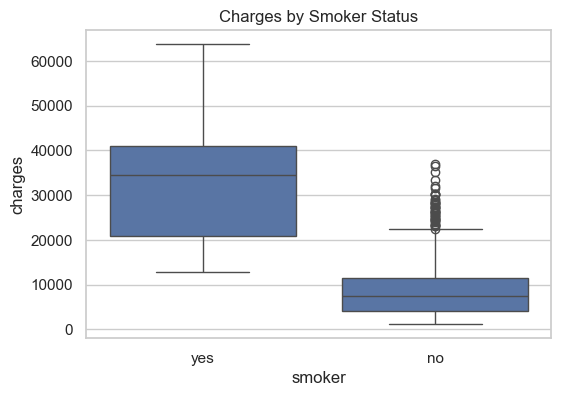

In [17]:
# ------------------------------
# Boxplot of charges by smoker status
# ------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title("Charges by Smoker Status")
plt.show()

`Note:`<br>
- Smokers clearly have higher medical charges on average.
- There’s more spread for smokers, showing extreme high cost cases.
- This shows that smoker may also be a strong predictor.

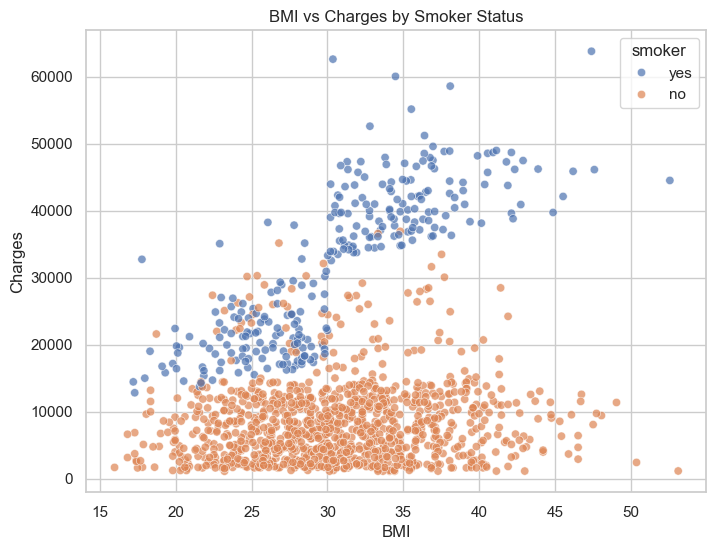

In [18]:
# ------------------------------
# Scatter plot of BMI vs charges, colored by smoker
# ------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.7)
plt.title("BMI vs Charges by Smoker Status")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

`Note:`<br>
- High BMI combined with being a smoker tends to correspond to the highest charges.

### 2.2 Handle missing values and clean data
- First, I'll transform outliers for `charges` to reduce skew.
- Then, I'll convert the categorical features to numerical using one-hot encoding.
- After that, I’ll convert the boolean columns created by one-hot encoding to integers so they’re ready for scaling.

**Important:** When I train a model on charges_log, i'll need to exponentiate the predictions (np.exp(predictions)) to get them back to dollar amounts. This will make the results meaningful for real world interpretation.

In [19]:
# Log-transform charges to reduce skew / outlier effect
df['charges_log'] = np.log(df['charges'])

In [20]:
# One-hot encode categorical features
categorical_cols = ["sex", "smoker", "region"]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Convert all boolean columns to integers
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

print("\nFirst 5 rows of cleaned data:")
print(df_encoded.head())


First 5 rows of cleaned data:
   age     bmi  children      charges  charges_log  sex_male  smoker_yes  \
0   19  27.900         0  16884.92400     9.734176         0           1   
1   18  33.770         1   1725.55230     7.453302         1           0   
2   28  33.000         3   4449.46200     8.400538         1           0   
3   33  22.705         0  21984.47061     9.998092         1           0   
4   32  28.880         0   3866.85520     8.260197         1           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 0                 1  
1                 0                 1                 0  
2                 0                 1                 0  
3                 1                 0                 0  
4                 1                 0                 0  


`Note:`<br>
- 0 = False
- 1 = True

### 2.3 Feature selection and engineering
- I'll create a new feature, `smoker_bmi` to capture the combined effect of smoking and BMI.
- Then, I'll scale numeric features to prepare for future pipelines and modeling.

In [21]:
# Create smoker + bmi feature
df_encoded['smoker_bmi'] = df_encoded['smoker_yes'] * df_encoded['bmi']

# Check the first 5 rows
df_encoded[['smoker_yes', 'bmi', 'smoker_bmi']].head()

,smoker_yes,bmi,smoker_bmi
0,1,27.900,27.9
1,0,33.770,0.0
2,0,33.000,0.0
3,0,22.705,0.0
4,0,28.880,0.0


In [ ]:
# Scale numeric features only
numeric_features = ['age', 'bmi', 'children', 'smoker_bmi']
scaler = StandardScaler()

df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

print(df_encoded.head())

        age       bmi  children      charges  charges_log  sex_male  \
0 -1.438764 -0.453320 -0.908614  16884.92400     9.734176         0   
1 -1.509965  0.509621 -0.078767   1725.55230     7.453302         1   
2 -0.797954  0.383307  1.580926   4449.46200     8.400538         1   
3 -0.441948 -1.305531 -0.908614  21984.47061     9.998092         1   
4 -0.513149 -0.292556 -0.908614   3866.85520     8.260197         1   

   smoker_yes  region_northwest  region_southeast  region_southwest  \
0           1                 0                 0                 1   
1           0                 0                 1                 0   
2           0                 0                 1                 0   
3           0                 1                 0                 0   
4           0                 1                 0                 0   

   smoker_bmi  
0    1.699463  
1   -0.494516  
2   -0.494516  
3   -0.494516  
4   -0.494516  


**Reflection 2:**
- What patterns or anomalies do you see?
  - Charges is heavily skewed and some extreme values stand out, so I added a log version for modeling.
- Do any features stand out? What preprocessing steps were necessary to clean and improve the data? 
  - The smoker feature really jumps out as an important predictor, especially when combined with BMI, which is why I created the `smoker_bmi` feature.
- Did you create or modify any features to improve performance?
  - Categorical variables needed one-hot encoding to work with regression, and numeric predictors were scaled to make them ready for the pipeline.

## Section 3. Feature Selection and Justification
### 3.1 Choose features and target
**Input features:**
- `age`, `bmi`, `children`, `sex_male`, `smoker_yes`, `region_northwest`, `region_southeast`, `region_southwest`, `smoker_bmi`

**Target variable:**
- `charges_log` (i'm modeling on the transformed target)


**Justification:**
- I selected these features because they all relate directly to medical costs.
- `age`, `bmi`, and `children` are known risk factors.
- Smoker status has a big impact on charges.
- Region may capture geographic cost differences.
- Sex can influence health risk.
- The new `smoker_bmi` feature was added to see how smoking and BMI together affect charges.


## 3.2 Define X and y
- Assign input features to X
- Assign target variable to y


In [23]:
X = df_encoded[['age', 'bmi', 'children', 'sex_male', 
                'smoker_yes', 'region_northwest', 
                'region_southeast', 'region_southwest', 
                'smoker_bmi']]
y = df_encoded['charges_log']


**Reflection 3:**
- Why did you choose these features?
  - They all relate to medical costs, and the new `smoker_bmi` feature captures combined effects that single features can’t.
- How might they impact predictions or accuracy?
  - These features help the model account for differences in patient profiles and should boost prediction accuracy.

`Note:` Using all these features, including the one-hot columns and smoker_bmi, could sometimes add extra noise or make the model a bit unstable. I'll keep an eye on performance and simplify if things start to overfit.

## Section 4. Train a Model (Linear Regression)
In this section, I’ll start with a simple baseline model to see how well it can predict medical charges before leveling up with polynomial features and pipelines.

### 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).

In [24]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 4.2 Train model using Scikit-Learn model.fit() method

In [25]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the Model
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 4.3 Evalulate performance
- First, I'll check how well the model predicts the transformed targed `charges_log` using R², MAE, and RMSE.
- Later, I’ll also look at MAE and RMSE on the dollar scale to see the real-world price of the errors.

In [26]:
# Predict on test data (log scale)
y_pred_log = lr_model.predict(X_test)

# Calculate metrics on log-transformed target
r2_log = r2_score(y_test, y_pred_log)
mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

print("Metrics on charges_log (log scale):")
print(f"R²: {r2_log:.4f}")
print(f"MAE: {mae_log:.4f}")
print(f"RMSE: {rmse_log:.4f}")

# Convert predictions back to original dollar amounts
y_pred_dollars = np.exp(y_pred_log)
y_test_dollars = np.exp(y_test)

# Calculate metrics on original scale
r2_dollars = r2_score(y_test_dollars, y_pred_dollars)
mae_dollars = mean_absolute_error(y_test_dollars, y_pred_dollars)
rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars))

print("\nMetrics on charges (dollars):")
print(f"R²: {r2_dollars:.4f}")
print(f"MAE: ${mae_dollars:,.2f}")
print(f"RMSE: ${rmse_dollars:,.2f}")

Metrics on charges_log (log scale):
R²: 0.8170
MAE: 0.2540
RMSE: 0.4057

Metrics on charges (dollars):
R²: 0.5278
MAE: $3,974.99
RMSE: $8,561.67


**Reflection 4:**
- How well did the model perform?
  - The model does a pretty good job capturing patterns in the log-transformed target, with an R² of about 0.82. On the actual dollar scale, the R² drops to around 0.53, which makes sense given the extreme high-cost cases.
- Any surprises in the results?
  - In real terms, the model’s predictions are off by about 4,000 dollars on average (MAE) and around 8,500 dollars for larger errors (RMSE). The skew in charges really stretches out the errors. It is interesting to see how much the log transform helped stabilize things.

## Section 5. Improve the Model or Try Alternates (Implement Pipelines)
### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.

In [27]:
# Create the pipeline
pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # handles missing values (none in this dataset)
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Fit pipeline on training data
pipeline1.fit(X_train, y_train)

# Predict on test data
y_pred_pipeline1 = pipeline1.predict(X_test)

# Evaluate performance
r2_pipe1 = r2_score(y_test, y_pred_pipeline1)
mae_pipe1 = mean_absolute_error(y_test, y_pred_pipeline1)
rmse_pipe1 = np.sqrt(mean_squared_error(y_test, y_pred_pipeline1))

print("Pipeline 1 Metrics on charges_log (log scale):")
print(f"R²: {r2_pipe1:.4f}")
print(f"MAE: {mae_pipe1:.4f}")
print(f"RMSE: {rmse_pipe1:.4f}")

# Convert predictions back to dollar amounts
y_pred_pipe1_dollars = np.exp(y_pred_pipeline1)
y_test_dollars = np.exp(y_test)

mae_pipe1_dollars = mean_absolute_error(y_test_dollars, y_pred_pipe1_dollars)
rmse_pipe1_dollars = np.sqrt(mean_squared_error(y_test_dollars, y_pred_pipe1_dollars))

print("\nPipeline 1 Metrics on charges (dollars):")
print(f"MAE: ${mae_pipe1_dollars:,.2f}")
print(f"RMSE: ${rmse_pipe1_dollars:,.2f}")


Pipeline 1 Metrics on charges_log (log scale):
R²: 0.8170
MAE: 0.2540
RMSE: 0.4057

Pipeline 1 Metrics on charges (dollars):
MAE: $3,974.99
RMSE: $8,561.67


`Note:`<br>
- The results of this pipeline match the earlier model, and including scaling and an imputer makes it flexible for use in future datasets. It automates preprocessing and linear regression. 
- The imputer and scaler don’t change the results here because:
  - There are no missing values in this dataset, so the imputer doesn’t modify anything.
  - Linear regression isn’t sensitive to feature scale, so scaling doesn’t affect predictions.


### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.

In [28]:
# Create the pipeline
pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Fit pipeline on training data
pipeline2.fit(X_train, y_train)

# Predict on test data
y_pred_pipeline2 = pipeline2.predict(X_test)

# Evaluate performance on log scale
r2_pipe2 = r2_score(y_test, y_pred_pipeline2)
mae_pipe2 = mean_absolute_error(y_test, y_pred_pipeline2)
rmse_pipe2 = np.sqrt(mean_squared_error(y_test, y_pred_pipeline2))

print("Pipeline 2 Metrics on charges_log (log scale):")
print(f"R²: {r2_pipe2:.4f}")
print(f"MAE: {mae_pipe2:.4f}")
print(f"RMSE: {rmse_pipe2:.4f}")

# Convert predictions back to dollar amounts
y_pred_pipe2_dollars = np.exp(y_pred_pipeline2)

mae_pipe2_dollars = mean_absolute_error(y_test_dollars, y_pred_pipe2_dollars)
rmse_pipe2_dollars = np.sqrt(mean_squared_error(y_test_dollars, y_pred_pipe2_dollars))

print("\nPipeline 2 Metrics on charges (dollars):")
print(f"MAE: ${mae_pipe2_dollars:,.2f}")
print(f"RMSE: ${rmse_pipe2_dollars:,.2f}")

Pipeline 2 Metrics on charges_log (log scale):
R²: 0.8458
MAE: 0.2156
RMSE: 0.3724

Pipeline 2 Metrics on charges (dollars):
MAE: $2,795.77
RMSE: $6,097.05


`Note:`<br>
- Pipeline 2 improved the model compared to Pipeline 1, with R² going up on the log scale (0.82 to 0.85) and MAE/RMSE dropping in dollars.
- Adding polynomial features helped capture some nonlinear relationships between the predictors and charges, which reduced errors for high-cost cases.

### 5.3 Compare performance of all models across the same performance metrics

| Model                      | R² (log) | MAE (log) | RMSE (log) | MAE ($)  | RMSE ($) |
| -------------------------- | -------- | --------- | ---------- | -------- | -------- |
| Baseline Linear Regression | 0.8170   | 0.2540    | 0.4057     | 3,974.99 | 8,561.67 |
| Pipeline 1                 | 0.8170   | 0.2540    | 0.4057     | 3,974.99 | 8,561.67 |
| Pipeline 2                 | 0.8458   | 0.2156    | 0.3724     | 2,795.77 | 6,097.05 |


**Reflection 5:**
- Which models performed better?
  - Pipeline 2 performed the best. R² improved on the log scale and MAE/RMSE dropped in dollars, so it’s capturing patterns that the simpler linear model missed.
- How does scaling impact results?
  - **Pipeline 1:** Scaling didn’t change the results because linear regression isn’t sensitive to feature scale, and there were no missing values anyway. The pipeline just makes preprocessing consistent and ready for future datasets.
  
  - **Pipeline 2:** Scaling matters here because of the polynomial features. Without scaling, the squared and cubed terms can get very large and make the model unstable. Scaling keeps all features on a similar scale, which stabilizes training and improves predictions.

## Section 6. Final Thoughts & Insights
### 6.1 Summarize findings
- The polynomial pipeline (Pipeline 2) gave the best predictions, improving R² and reducing MAE/RMSE compared to the simple linear model.

- `smoking`, `age`, and `bmi`, (especially combined as `smoker_bmi`) were the strongest predictors of medical charges.

- Transforming the target with a log scale helped stabilize variance and improved the model fit.

- The scatter plots below show predicted vs actual charges (in dollars) for Pipeline 1 and Pipeline 2, highlighting how well each model performs overall and where extreme costs are harder to predict.

In [29]:
# Convert log-transformed target back to original dollar amounts
y_test_dollars = np.exp(y_test)

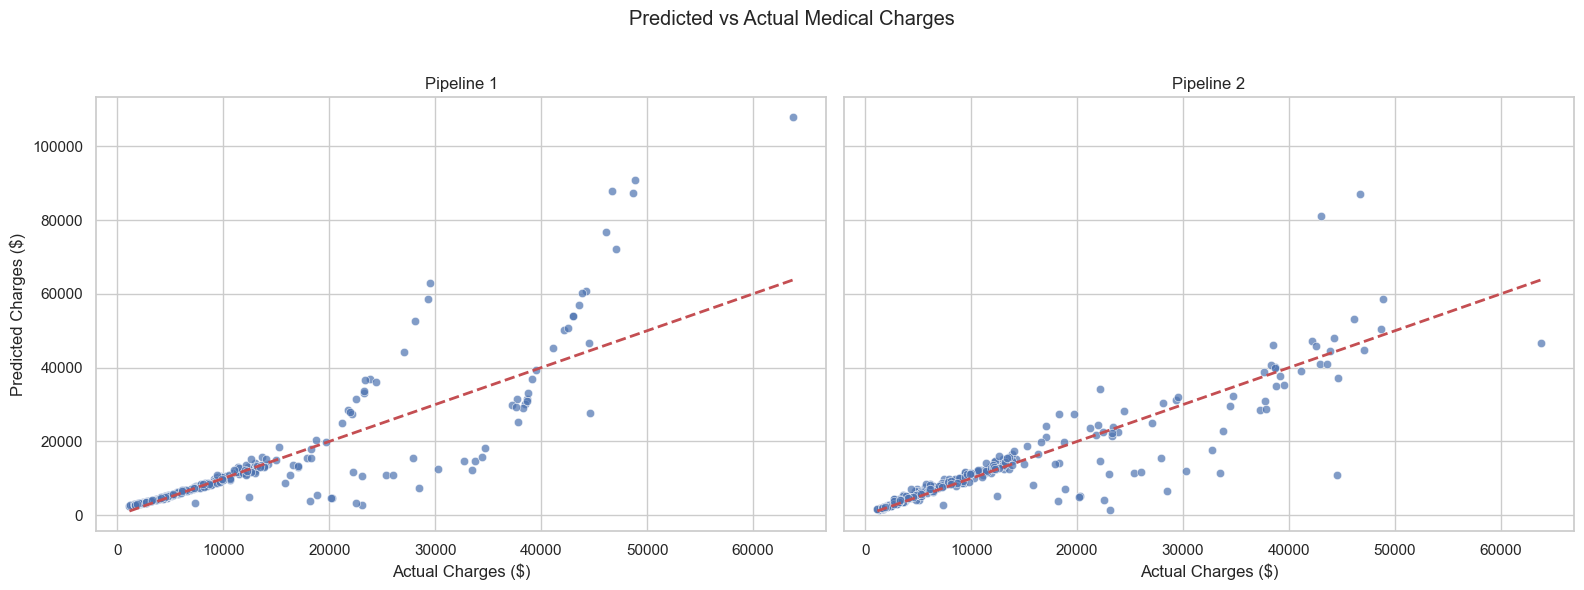

In [30]:
# Side-by-side scatter plots for Pipeline 1 and Pipeline 2
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# Pipeline 1
sns.scatterplot(x=y_test_dollars, y=y_pred_pipe1_dollars, alpha=0.7, ax=axes[0])
axes[0].plot([y_test_dollars.min(), y_test_dollars.max()],
             [y_test_dollars.min(), y_test_dollars.max()],
             'r--', lw=2)
axes[0].set_xlabel("Actual Charges ($)")
axes[0].set_ylabel("Predicted Charges ($)")
axes[0].set_title("Pipeline 1")

# Pipeline 2
sns.scatterplot(x=y_test_dollars, y=y_pred_pipe2_dollars, alpha=0.7, ax=axes[1])
axes[1].plot([y_test_dollars.min(), y_test_dollars.max()],
             [y_test_dollars.min(), y_test_dollars.max()],
             'r--', lw=2)
axes[1].set_xlabel("Actual Charges ($)")
axes[1].set_ylabel("Predicted Charges ($)")
axes[1].set_title("Pipeline 2")

plt.suptitle("Predicted vs Actual Medical Charges")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


`Note:`<br>
- Pipeline 1 struggled to predict actual charges, both at mid-range and high levels.
- Pipeline 2 fits much better overall, but predictions still struggle with the very highest charges. There’s room for improvement.

### 6.2 Discuss challenges faced
- Handling skewed target values required a log transformation to get meaningful regression results.

- Adding polynomial features improved performance but made the model harder to explain.

- Making sure metrics were consistent across log scale vs. dollar scale took a lot of trial and error.

### 6.3 If you had more time, what would you try next?
- Create more features, or try regularization like Ridge/Lasso to see if it improves generalization.

- Experiment with Random Forests to see how they capture nonlinear patterns.

**Reflection 6:**
- What did you learn from this project?
  - This project was a great way to see how different features affect medical charges and how modeling choices impact predictions. I learned that `smoking`, `age`, `bmi`, and especially the `smoker_bmi` feature are key drivers of cost. I also learned that transforming the target with a log scale really helps the model handle skewed data. Comparing the pipelines showed how a simple linear model can get you part of the way there, but adding polynomial features improves accuracy, especially for those mid-range charges.
  
  - Overall, this project gave me a solid feel for preprocessing, feature engineering, and evaluating regression models. It was so exciting to see how predictions in actual dollar amounts really connect the model to real-world impact. It’s one thing to have a good R², but it’s another to understand how much you might be off in actual costs!